In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2 as cv
import math

import tensorflow as tf

from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau

In [2]:
image_size = 256

labels = ['Epidural','Intraparenchymal','Intraventricular',
          'Subarachnoid','Subdural']

In [3]:
df_train=pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_val = pd.read_csv('val.csv')

In [4]:
df_train.head()

,ID,Epidural,Intraparenchymal,Intraventricular,Subarachnoid,Subdural
0,ID_e3b0375dc.png,0,0,1,0,0
1,ID_af34a4d21.png,0,0,1,0,0
2,ID_c0c165f8c.png,0,0,0,1,0
3,ID_e47a423ce.png,0,0,0,0,1
4,ID_188917a1b.png,0,1,0,0,0


In [5]:
df_val.head()

,ID,Epidural,Intraparenchymal,Intraventricular,Subarachnoid,Subdural
0,ID_bd52b8cca.png,0,0,1,0,0
1,ID_959774a6b.png,0,0,0,1,0
2,ID_7947f16c6.png,0,0,0,0,1
3,ID_78cb74349.png,0,0,0,0,1
4,ID_92046d5d0.png,0,0,1,0,0


In [6]:
df_test.head()

,ID,Epidural,Intraparenchymal,Intraventricular,Subarachnoid,Subdural
0,ID_8e2c3d201.png,0,1,0,0,0
1,ID_c703a1b86.png,0,0,0,0,1
2,ID_df9606689.png,0,0,0,1,0
3,ID_0babb9afe.png,0,0,0,0,1
4,ID_851d99c81.png,0,0,0,0,1


In [7]:
def get_train_generator(df, image_dir, x_col, y_cols, shuffle=True, batch_size=16, seed=1):
    """
    Return generator for training set, normalizing using batch
    statistics.

    Args:
      train_df (dataframe): dataframe specifying training data.
      image_dir (str): directory where image files are held.
      x_col (str): name of column in df that holds filenames.
      y_cols (list): list of strings that hold y labels for images.
      batch_size (int): images per batch to be fed into model during training.
      seed (int): random seed.
      target_w (int): final width of input images.
      target_h (int): final height of input images.
    
    Returns:
        train_generator (DataFrameIterator): iterator over training set
    """        
    print("getting train generator...") 
    # normalize images
    image_generator = ImageDataGenerator(preprocessing_function=preprocess_input,
                                        horizontal_flip=True,
                                        rotation_range = 90,
                                        shear_range=0.2,
                                        zoom_range=0.1,
                                        width_shift_range=0.1,
                                        height_shift_range=0.1,
                                        fill_mode='nearest', cval=0.0)
    
    # flow from directory with specified batch size
    # and target image size
    generator = image_generator.flow_from_dataframe(
            dataframe=df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed)
    
    return generator

In [8]:
def get_test_and_valid_generator(valid_df, test_df, train_df, image_dir, x_col, y_cols, 
                                 sample_size=500, batch_size=16, seed=1):
    """
    Return generator for validation set and test test set using 
    normalization statistics from training set.

    Args:
      valid_df (dataframe): dataframe specifying validation data.
      test_df (dataframe): dataframe specifying test data.
      train_df (dataframe): dataframe specifying training data.
      image_dir (str): directory where image files are held.
      x_col (str): name of column in df that holds filenames.
      y_cols (list): list of strings that hold y labels for images.
      sample_size (int): size of sample to use for normalization statistics.
      batch_size (int): images per batch to be fed into model during training.
      seed (int): random seed.
      target_w (int): final width of input images.
      target_h (int): final height of input images.
    
    Returns:
        test_generator (DataFrameIterator) and valid_generator: iterators over test set and validation set respectively
    """
    print("getting train and valid generators...")
    # get generator to sample dataset
    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe=train_df, 
        directory=IMAGE_DIR, 
        x_col=x_col, 
        y_col=y_cols, 
        class_mode="raw", 
        batch_size=sample_size, 
        shuffle=True)
    
    # get data sample
    batch = raw_train_generator.next()
    data_sample = batch[0]

    # use sample to fit mean and std for test set generator
    image_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
    
    # fit generator to sample from training data
    image_generator.fit(data_sample)

    # get test generator
    valid_generator = image_generator.flow_from_dataframe(
            dataframe=valid_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed)

    test_generator = image_generator.flow_from_dataframe(
            dataframe=test_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed)
    
    return valid_generator, test_generator

In [9]:
IMAGE_DIR = "C:/Users/asarkar.NATICK-NT/ICH_dataset/ICH_png"
train_generator = get_train_generator(df_train, IMAGE_DIR, "ID", labels)
valid_generator, test_generator= get_test_and_valid_generator(df_val, df_test, df_train, IMAGE_DIR, "ID", labels)

getting train generator...
Found 48290 validated image filenames.
getting train and valid generators...
Found 48290 validated image filenames.
Found 10875 validated image filenames.
Found 13594 validated image filenames.


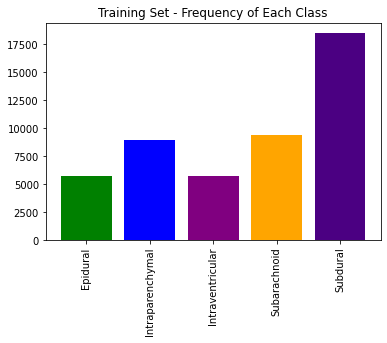

In [10]:
plt.xticks(rotation=90)
colours = ['green','blue','purple','orange','indigo']
plt.bar(x=labels, height=np.sum(train_generator.labels, axis=0), color=colours)
plt.title("Training Set - Frequency of Each Class")
plt.show()

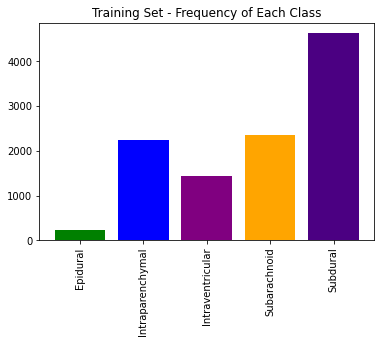

In [11]:
plt.xticks(rotation=90)
colours = ['green','blue','purple','orange','indigo']
plt.bar(x=labels, height=np.sum(valid_generator.labels, axis=0), color=colours)
plt.title("Training Set - Frequency of Each Class")
plt.show()

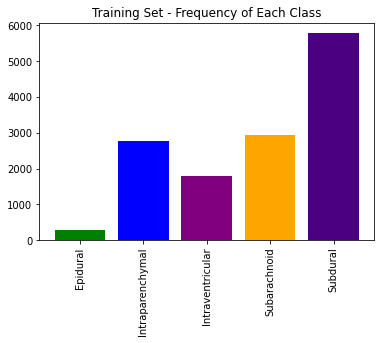

In [12]:
plt.xticks(rotation=90)
colours = ['green','blue','purple','orange','indigo']
plt.bar(x=labels, height=np.sum(test_generator.labels, axis=0), color=colours)
plt.title("Training Set - Frequency of Each Class")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


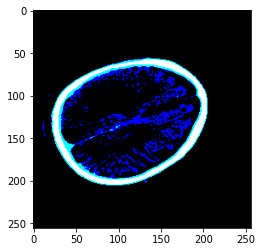

In [13]:
x, y = train_generator.__getitem__(3)
plt.imshow(x[0], cmap = 'gray')

In [14]:
y[0]

array([0, 0, 0, 1, 0], dtype=int64)

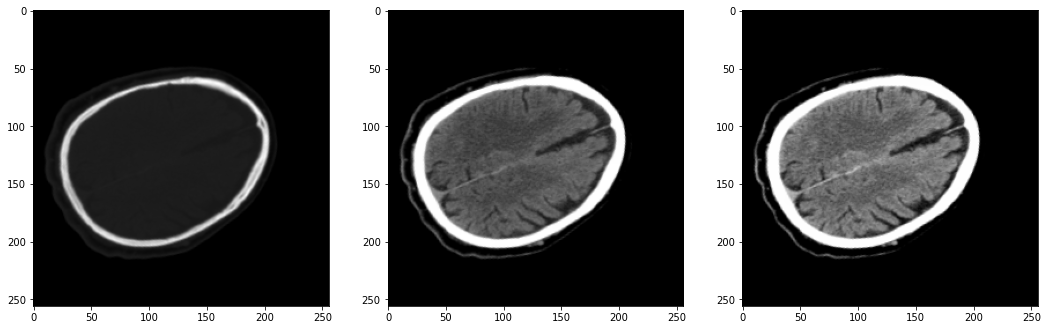

In [15]:
blue, green, red = cv.split(x[0])

fig = plt.figure(figsize = (18, 8))
ax1 = fig.add_subplot(1, 3, 1)
ax1.imshow(blue, cmap = 'gray')
ax2 = fig.add_subplot(1, 3, 2)
ax2.imshow(green, cmap = 'gray')
ax3 = fig.add_subplot(1, 3, 3)
ax3.imshow(red, cmap='gray')

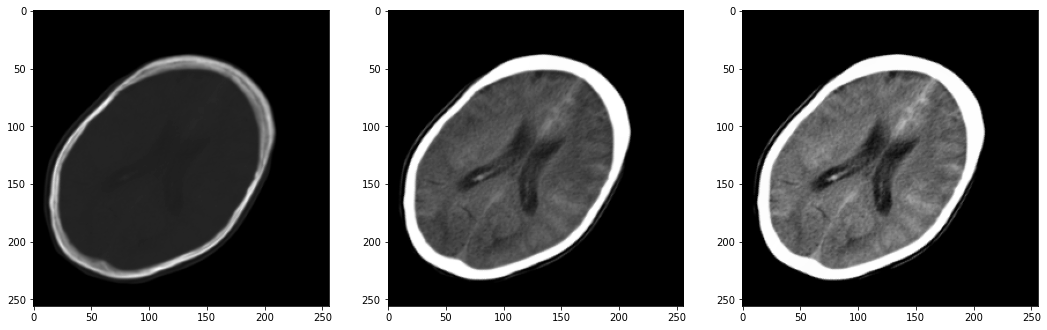

In [16]:
blue, green, red = cv.split(x[1])

fig = plt.figure(figsize = (18, 8))
ax1 = fig.add_subplot(1, 3, 1)
ax1.imshow(blue, cmap = 'gray')
ax2 = fig.add_subplot(1, 3, 2)
ax2.imshow(green, cmap = 'gray')
ax3 = fig.add_subplot(1, 3, 3)
ax3.imshow(red, cmap='gray')

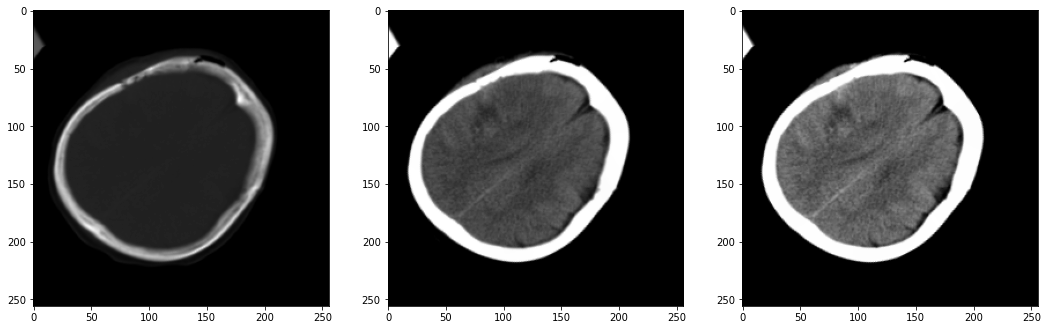

In [17]:
blue, green, red = cv.split(x[2])

fig = plt.figure(figsize = (18, 8))
ax1 = fig.add_subplot(1, 3, 1)
ax1.imshow(blue, cmap = 'gray')
ax2 = fig.add_subplot(1, 3, 2)
ax2.imshow(green, cmap = 'gray')
ax3 = fig.add_subplot(1, 3, 3)
ax3.imshow(red, cmap='gray')

In [18]:
def compute_class_freqs(labels):
    """
    Compute positive and negative frequences for each class.

    Args:
        labels (np.array): matrix of labels, size (num_examples, num_classes)
    Returns:
        positive_frequencies (np.array): array of positive frequences for each
                                         class, size (num_classes)
        negative_frequencies (np.array): array of negative frequences for each
                                         class, size (num_classes)
    """
    
    # total number of patients (rows)
    N = labels.shape[0]
    
    positive_frequencies = np.sum(labels==True,axis=0)/N
    negative_frequencies = np.sum(labels==False, axis=0)/N

    return positive_frequencies, negative_frequencies

In [19]:
freq_pos, freq_neg = compute_class_freqs(train_generator.labels)
freq_pos

array([0.11903086, 0.18465521, 0.1181404 , 0.19503003, 0.38314351])

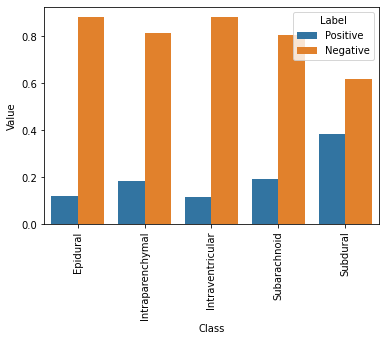

In [20]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": freq_pos})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)], ignore_index=True)
plt.xticks(rotation=90)
f = sns.barplot(x="Class", y="Value", hue="Label" ,data=data)

<AxesSubplot:xlabel='Class', ylabel='Value'>

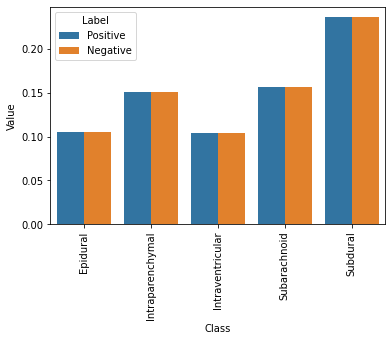

In [21]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights 
neg_contribution = freq_neg * neg_weights

data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": pos_contribution})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} 
                        for l,v in enumerate(neg_contribution)], ignore_index=True)
plt.xticks(rotation=90)
sns.barplot(x="Class", y="Value", hue="Label" ,data=data)

In [22]:
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    """
    Return weighted loss function given negative weights and positive weights.

    Args:
      pos_weights (np.array): array of positive weights for each class, size (num_classes)
      neg_weights (np.array): array of negative weights for each class, size (num_classes)
    
    Returns:
      weighted_loss (function): weighted loss function
    """
    def weighted_loss(y_true, y_pred):
        """
        Return weighted loss value. 

        Args:
            y_true (Tensor): Tensor of true labels, size is (num_examples, num_classes)
            y_pred (Tensor): Tensor of predicted labels, size is (num_examples, num_classes)
        Returns:
            loss (Float): overall scalar loss summed across all classes
        """
        # initialize loss to zero
        loss = 0.0

        for i in range(len(pos_weights)):
            
            y_true = tf.cast(y_true, tf.float32)
            y_pred = tf.cast(y_pred, tf.float32)
            

            # for each class, add average weighted loss for that class 
            loss += K.mean(-(pos_weights[i] *y_true[:,i] * K.log(y_pred[:,i] + epsilon) 
                     + neg_weights[i]* (1 - y_true[:,i]) * K.log( 1 - y_pred[:,i] + epsilon)))   
            
        return loss
    
    return weighted_loss

In [23]:
# create the base pre-trained model
base_model = ResNet50(weights = 'imagenet',include_top=False)

x = base_model.output

# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)

x = Dense(1024, kernel_regularizer=l2(0.0003),activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(1024, kernel_regularizer=l2(0.0003),activation='relu')(x)
x = Dropout(0.2)(x)

# and a logistic layer
predictions = Dense(5, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss= get_weighted_loss(pos_weights, neg_weights), metrics = ['accuracy'])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [24]:
lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

stopping = EarlyStopping(monitor='val_loss', patience=10)

callbacks = ModelCheckpoint('Resnet_aug.h5', monitor='val_loss', save_best_only=True, mode = 'auto')

Epoch 1/100
2719/2719 [==============================] - 503s 185ms/step - loss: 1.0993 - accuracy: 0.2766 - val_loss: 1.0007 - val_accuracy: 0.3111
Epoch 2/100
2719/2719 [==============================] - 478s 176ms/step - loss: 0.9909 - accuracy: 0.3225 - val_loss: 1.0673 - val_accuracy: 0.4077
Epoch 3/100
2719/2719 [==============================] - 474s 174ms/step - loss: 0.9397 - accuracy: 0.3844 - val_loss: 1.2860 - val_accuracy: 0.1877
Epoch 4/100
2719/2719 [==============================] - 481s 177ms/step - loss: 0.8694 - accuracy: 0.4749 - val_loss: 1.2624 - val_accuracy: 0.2094
Epoch 5/100
2719/2719 [==============================] - 491s 180ms/step - loss: 0.8043 - accuracy: 0.5341 - val_loss: 1.3291 - val_accuracy: 0.2177
Epoch 6/100
2719/2719 [==============================] - 483s 178ms/step - loss: 0.7385 - accuracy: 0.5816 - val_loss: 0.6966 - val_accuracy: 0.5777
Epoch 7/100
2719/2719 [==============================] - 484s 178ms/step - loss: 0.6887 - accuracy: 0.6182

2719/2719 [==============================] - 473s 174ms/step - loss: 0.4305 - accuracy: 0.7765 - val_loss: 0.5067 - val_accuracy: 0.7514
Epoch 54/100
2719/2719 [==============================] - 473s 174ms/step - loss: 0.4305 - accuracy: 0.7772 - val_loss: 0.5033 - val_accuracy: 0.7544
Epoch 55/100
2719/2719 [==============================] - 473s 174ms/step - loss: 0.4311 - accuracy: 0.7766 - val_loss: 0.5037 - val_accuracy: 0.7536
Epoch 56/100
2719/2719 [==============================] - 474s 174ms/step - loss: 0.4290 - accuracy: 0.7784 - val_loss: 0.5058 - val_accuracy: 0.7526
Epoch 57/100
2719/2719 [==============================] - 475s 175ms/step - loss: 0.4300 - accuracy: 0.7756 - val_loss: 0.4998 - val_accuracy: 0.7559
Epoch 58/100
2719/2719 [==============================] - 481s 177ms/step - loss: 0.4274 - accuracy: 0.7775 - val_loss: 0.5023 - val_accuracy: 0.7549


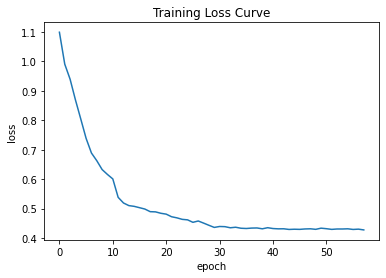

In [25]:
batch_size = 16

train = 43500
val = 10875
compute_steps_per_epoch = lambda x: int(math.ceil(1. * x / batch_size))

steps_per_epoch = compute_steps_per_epoch(train)
val_steps = compute_steps_per_epoch(val)

history = model.fit(train_generator, 
                              validation_data=valid_generator,
                              steps_per_epoch=steps_per_epoch, 
                              validation_steps=val_steps, 
                              epochs = 100,
                              callbacks = [callbacks,lr_schedule,stopping])

plt.plot(history.history['loss'])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("Training Loss Curve")
plt.show()

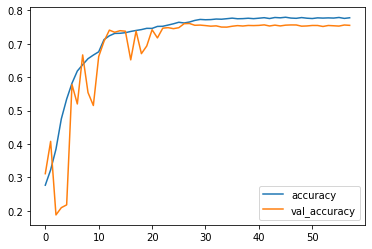

In [26]:
plt.plot(history.history['accuracy'],label='accuracy')
plt.plot(history.history['val_accuracy'],label='val_accuracy')
plt.legend()

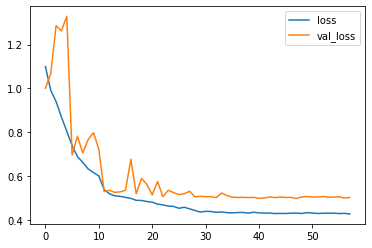

In [27]:
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.legend()

In [28]:
final_model = tf.keras.models.load_model('Resnet_aug.h5', compile = False)
final_model.compile(optimizer='adam', loss= get_weighted_loss(pos_weights, neg_weights), metrics = ['accuracy'])

In [29]:
predicted_vals = final_model.predict(test_generator, steps = len(test_generator))

([<matplotlib.axis.YTick at 0x1d54d6a51c8>,
 [Text(0, 0, 'Epidural'),
  Text(0, 1, 'Intraparenchymal'),
  Text(0, 2, 'Intraventricular'),
  Text(0, 3, 'Subarachnoid'),
  Text(0, 4, 'Subdural')])

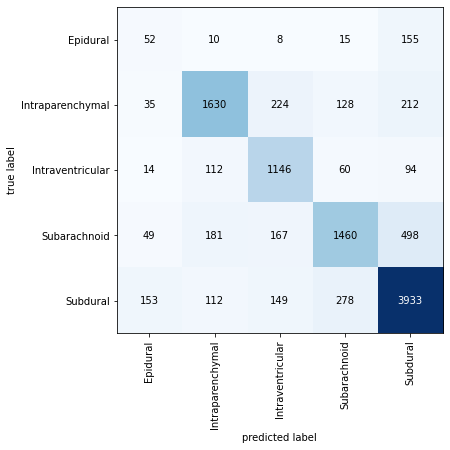

In [30]:
y_val = df_val[labels]
y_val = np.array(y_val)
y_val = np.argmax(y_val,axis=1)

P_val = final_model.predict(valid_generator, steps = len(valid_generator)).argmax(axis=1)

matrix = confusion_matrix (y_val, P_val)
plot_confusion_matrix(matrix, figsize=(6,6))
plt.xticks(rotation=90)
plt.xticks(range(5), labels, fontsize=10)
plt.yticks(range(5), labels, fontsize=10)

([<matplotlib.axis.YTick at 0x1d54d77b848>,
 [Text(0, 0, 'Epidural'),
  Text(0, 1, 'Intraparenchymal'),
  Text(0, 2, 'Intraventricular'),
  Text(0, 3, 'Subarachnoid'),
  Text(0, 4, 'Subdural')])

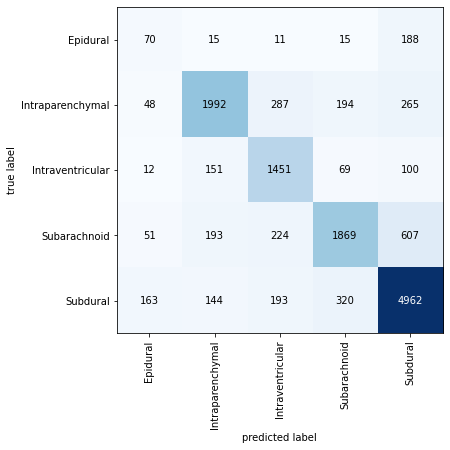

In [31]:
y_test = df_test[labels]
y_test = np.array(y_test)
y_test = np.argmax(y_test,axis=1)

P_test = final_model.predict(test_generator, steps = len(test_generator)).argmax(axis=1)

matrix = confusion_matrix (y_test, P_test)
plot_confusion_matrix(matrix, figsize=(6,6))
plt.xticks(rotation=90)
plt.xticks(range(5), labels, fontsize=10)
plt.yticks(range(5), labels, fontsize=10)

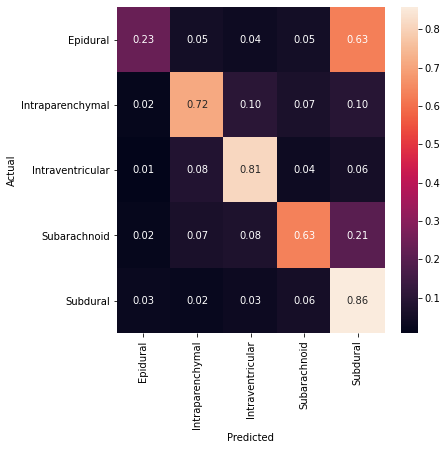

In [32]:
target_names = labels
cm = confusion_matrix(y_test, P_test)
# Normalise
cmn = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

In [33]:
import random

from tensorflow.keras.preprocessing import image
from sklearn.metrics import roc_auc_score, roc_curve

In [34]:
def get_roc_curve(labels, predicted_vals, generator):
    auc_roc_vals = []
    for i in range(len(labels)):
        try:
            gt = generator.labels[:, i]
            pred = predicted_vals[:, i]
            auc_roc = roc_auc_score(gt, pred)
            auc_roc_vals.append(auc_roc)
            fpr_rf, tpr_rf, _ = roc_curve(gt, pred)
            plt.figure(1, figsize=(10, 10))
            plt.plot([0, 1], [0, 1], 'k--')
            plt.plot(fpr_rf, tpr_rf,
                     label=labels[i] + " (" + str(round(auc_roc, 3)) + ")")
            plt.xlabel('False positive rate')
            plt.ylabel('True positive rate')
            plt.title('ROC curve')
            plt.legend(loc='best')
        except:
            print(
                f"Error in generating ROC curve for {labels[i]}. "
                f"Dataset lacks enough examples."
            )
    plt.show()
    return auc_roc_vals

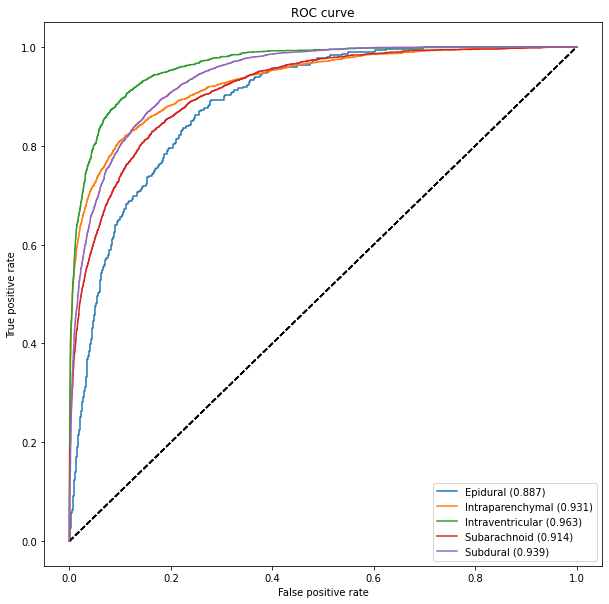

In [35]:
auc_rocs = get_roc_curve(labels, predicted_vals, test_generator)

In [36]:
def get_confusion_matrix_stats(y_actual, y_pred): 
    """
    This function calculates and returns the True Positive, True negative,
    False Positive and False negative values,
    and returns them
    """
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_pred)): 
        if y_actual[i]==y_pred[i]==1:
            TP += 1
        if y_pred[i]==1 and y_actual[i]!=y_pred[i]:
            FP += 1
        if y_actual[i]==y_pred[i]==0:
            TN += 1
        if y_pred[i]==0 and y_actual[i]!=y_pred[i]:
            FN += 1

    return(TP, FP, TN, FN)

def calculate_metrics(y_true,y_predicted,name):
    """
    This function calculates the Precision, Recall and F-score and returns them
    """
    y_actual = y_true
    y_pred = y_predicted
    tp, fp, tn ,fn = get_confusion_matrix_stats(y_actual, y_pred)

    precision = round((tp/(tp+fp)),2)
    recall = round((tp/(tp+fn)),2)
    f_score = round(((2*precision*recall)/(precision+recall)),2)

    print(f"Recall of {name} is = ",recall)
    print(f"Precision of {name} is = ",precision)
    print(f"F-Score is {name} is =",f_score)
    print()

In [37]:
#Use the helper function to find the True Positive, True negative, False Positive and False Negative values
tp, fp, tn, fn = get_confusion_matrix_stats(y_test, P_test)

print('True Positive = ',tp)
print('True Negative = ',tn)
print('False Positive = ',fp)
print('False Negative = ',fn)
print()

#Use the helper functions to find the Recall, Precision and F-score of the model
#and all classes seperately
calculate_metrics(y_test,P_test,'Model')
calculate_metrics(y_test==0,P_test==0,'Class - Epidural')
calculate_metrics(y_test==1,P_test==1,'Class - Intraparenchymal')
calculate_metrics(y_test==2,P_test==2,'Class - Intraventricular')
calculate_metrics(y_test==3,P_test==3,'Class - Subarachnoid')
calculate_metrics(y_test==4,P_test==4,'Class - Subdural')

True Positive =  1992
True Negative =  70
False Positive =  503
False Negative =  274

Recall of Model is =  0.88
Precision of Model is =  0.8
F-Score is Model is = 0.84

Recall of Class - Epidural is =  0.23
Precision of Class - Epidural is =  0.2
F-Score is Class - Epidural is = 0.21

Recall of Class - Intraparenchymal is =  0.72
Precision of Class - Intraparenchymal is =  0.8
F-Score is Class - Intraparenchymal is = 0.76

Recall of Class - Intraventricular is =  0.81
Precision of Class - Intraventricular is =  0.67
F-Score is Class - Intraventricular is = 0.73

Recall of Class - Subarachnoid is =  0.63
Precision of Class - Subarachnoid is =  0.76
F-Score is Class - Subarachnoid is = 0.69

Recall of Class - Subdural is =  0.86
Precision of Class - Subdural is =  0.81
F-Score is Class - Subdural is = 0.83

